In [2]:
import os
import glob
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

AttributeError: module 'bottleneck' has no attribute '__version__'

In [2]:
all_Acq_files = glob.glob(os.path.join("RawData/Acquisition*.txt"))
all_perf_files = glob.glob(os.path.join( "RawData/Performance_*.txt"))

In [3]:
def af_merge(f1,f2):
    df = pd.read_csv(f1,sep ="|", index_col=None, header=None)
    df.rename(columns={
                        0: 'Loan_ID',
                        1: 'Channel',
                        2: 'Seller',
                        3: 'Interest_Rate',
                        4: 'UPB',
                        5: 'Loan_Term',
                        6: 'Origination_Date',
                        7: 'First_Payment_Date',
                        8: 'LTV',
                        9: 'CLTV',
                        10: 'Num_Borrowers',
                        11: 'DTI',
                        12: 'Borrower_FICO',
                        13: 'First_Time_Buyer',
                        14: 'Loan_Purpose',
                        15: 'Dwelling_Type',
                        16: 'Unit_Count',
                        17: 'Occupancy',
                        18: 'State',
                        19: 'Zip',
                        20: 'Insurance%',
                        21: 'Product',
                        22: 'Co_Borrower_FICO',
                        23: 'Mortgage_Insurance_Type',
                        24: 'Relocation_Indicator'}, inplace=True)
    perf_df = pd.read_csv(f2,sep ="|", index_col=None, header=None
                                     ,usecols=[0,1,3,4,5,11,12]
                                     , names = ['Loan_ID', 'Period', 'Current_IR','Current_UPB', 'Age',
                                                'Mod_Ind','Zero_Bal_Cd']
                                     ,dtype = { 'Loan_ID' : np.int64, 'Current_IR' : np.float64, 
                                               'Current_UPB': np.float64}
                                    ) 
    ## Modify the date field ("Period") to be a number for easier manipulation
    ## later on in the script
    ## 
    perf_df['Period']=perf_df['Period'].apply(str).str[6:].apply(int)*100+perf_df['Period'].apply(str).str[:2].apply(int)

    ## Select the latest period in the data frame as we're concerned with the most recent loan status
    ##
    idx = perf_df.groupby(['Loan_ID'])['Period'].transform(max) == perf_df['Period']

    ## Create a new data frame with just the latest period record
    ## 
    perf_df_new = perf_df[idx].copy()
    ## In looking at the FAQ dor the datasets we know that if the zero balance code is null then the loan is current
    ## meaning it's paid up correctly. It's not late, or paid off early, or in default so we don't really care
    ## about those records as regards our analysis.
    ##
    perf_df_new.Zero_Bal_Cd.fillna(0,inplace=True)

    ## Also, some of the loans are missing the UPB (unpaid balance). We can't use that data in building our model
    ## so we'll just drop those loans from the dataframe
    ##
    perf_df_new.dropna(inplace=True)

    ## create a mapping of the available zero_balance_code numbers and their meanings
    ##
    zero_bal_cd_map = {0:'Current',1:'Prepaid',2:'Third Party Sale',3:'Short Sale',
                       6:'Repurchase',9:'REO',15:'Note Sale',16:'RPL Loan Sale'}
    perf_df_new['Zero_Bal_Cd'] = perf_df_new['Zero_Bal_Cd'].map(zero_bal_cd_map).apply(str)
    ## Now that we've cleaned up the acquisition and performance data, merge them into a single integrated
    ## data frame that we'll call "loan_df"
    ##
    loan_df = pd.merge(df,perf_df_new,how='inner',on='Loan_ID')
    return loan_df

In [4]:
df_2004 = af_merge(all_Acq_files[0],all_perf_files[0])
df_2008 = af_merge(all_Acq_files[1],all_perf_files[1])
df_2012 = af_merge(all_Acq_files[2],all_perf_files[2])
df_2016 = af_merge(all_Acq_files[3],all_perf_files[3])

df_files = [df_2004,df_2008,df_2012,df_2016]

loan_df   = pd.concat(df_files, ignore_index=True)
loan_df.head()

,Loan_ID,Channel,Seller,Interest_Rate,UPB,Loan_Term,Origination_Date,First_Payment_Date,LTV,CLTV,...,Product,Co_Borrower_FICO,Mortgage_Insurance_Type,Relocation_Indicator,Period,Current_IR,Current_UPB,Age,Mod_Ind,Zero_Bal_Cd
0,100001458647,R,"CITIMORTGAGE, INC.",5.625,297000,360,05/2004,07/2004,49,61.0,...,FRM,NaN,NaN,N,201309,5.625,251567.64,111,N,Prepaid
1,100004788186,C,"BANK OF AMERICA, N.A.",5.750,50000,180,08/2004,10/2004,25,25.0,...,FRM,753.0,NaN,N,201207,5.750,12621.76,94,N,Prepaid
2,100008528816,R,OTHER,5.000,80000,180,08/2004,10/2004,75,75.0,...,FRM,678.0,NaN,N,201508,5.000,40214.78,131,N,REO
3,100014656651,C,"BANK OF AMERICA, N.A.",6.300,55000,240,07/2004,09/2004,80,80.0,...,FRM,NaN,NaN,N,201402,6.300,37473.50,114,N,Prepaid
4,100021529837,C,"BANK OF AMERICA, N.A.",5.875,140000,360,07/2004,09/2004,80,80.0,...,FRM,794.0,NaN,N,201010,5.875,119759.31,74,N,Prepaid


In [5]:
loan_df.shape

(2081532, 31)

In [6]:
## Assign Defaults for the missing values in the loans dataframe
##
loan_df.Mortgage_Insurance_Type.fillna(0,inplace=True)
loan_df['Insurance%'].fillna(0,inplace=True)
loan_df.Num_Borrowers.fillna(1,inplace=True)
loan_df.CLTV.fillna(loan_df.LTV,inplace=True)
loan_df.drop('Co_Borrower_FICO',axis=1,inplace=True)
## Drop any records that still have null values - we don't want to include them in the model / analysis
##
loan_df.dropna(inplace=True)
## We'll do some analysis against the FICO (credit score) of the borrower
## Create several bins based on the FICO score range and add the calculated FICO bin score
## to each record in the dataframe
##
FICO_bins = [0,620,660,700,740,780,850]
FICO_labels = ['0-620', '620-660','660-700','700-740','740-780','780+']
loan_df['FICO_bins'] = pd.cut(loan_df['Borrower_FICO'],bins=FICO_bins,labels=FICO_labels)

Term_bins =[0,180,360]
Term_labels =['<=15 Years','<= 30 Years']
loan_df['Term_bins'] = pd.cut(loan_df['Loan_Term'],bins=Term_bins,labels=Term_labels)

zero_bal_cd_map = {'Current':'Current','Prepaid':'Prepaid','Third Party Sale':'Underperforming','Short Sale':'Underperforming',
                   'Repurchase':'Underperforming','REO':'Underperforming','Note Sale':'Underperforming','RPL Loan Sale':'Underperforming'}
loan_df['Current_Status'] = loan_df['Zero_Bal_Cd'].map(zero_bal_cd_map).apply(str)

loan_df['Origin_Month'],loan_df['Origin_Year'] = loan_df['First_Payment_Date'].str.split('/', 1).str

df = loan_df[loan_df['Origin_Year'].isin(['2004','2008','2012','2016'])]

## Create a new dataframe that holds the first 100,000 records
##
df2 = df.groupby('Origin_Year').head(100000) #take 100000 records from each group

In [10]:
#print(df.head()) #check how it is taking data
#print(df2.head()) #is order preserved? - order is preserved
df.groupby('Origin_Year').head(200000)

,Loan_ID,Channel,Seller,Interest_Rate,UPB,Loan_Term,Origination_Date,First_Payment_Date,LTV,CLTV,...,Current_IR,Current_UPB,Age,Mod_Ind,Zero_Bal_Cd,FICO_bins,Term_bins,Current_Status,Origin_Month,Origin_Year
0,100001458647,R,"CITIMORTGAGE, INC.",5.625,297000,360,05/2004,07/2004,49,61.0,...,5.625,251567.64,111,N,Prepaid,660-700,<= 30 Years,Prepaid,07,2004
1,100004788186,C,"BANK OF AMERICA, N.A.",5.750,50000,180,08/2004,10/2004,25,25.0,...,5.750,12621.76,94,N,Prepaid,740-780,<=15 Years,Prepaid,10,2004
2,100008528816,R,OTHER,5.000,80000,180,08/2004,10/2004,75,75.0,...,5.000,40214.78,131,N,REO,660-700,<=15 Years,Underperforming,10,2004
3,100014656651,C,"BANK OF AMERICA, N.A.",6.300,55000,240,07/2004,09/2004,80,80.0,...,6.300,37473.50,114,N,Prepaid,700-740,<= 30 Years,Prepaid,09,2004
4,100021529837,C,"BANK OF AMERICA, N.A.",5.875,140000,360,07/2004,09/2004,80,80.0,...,5.875,119759.31,74,N,Prepaid,740-780,<= 30 Years,Prepaid,09,2004
5,100024441477,B,SUNTRUST MORTGAGE INC.,6.250,119000,360,06/2004,08/2004,80,80.0,...,6.250,111867.54,57,N,Prepaid,660-700,<= 30 Years,Prepaid,08,2004
6,100027055100,C,"BANK OF AMERICA, N.A.",6.375,333000,360,07/2004,09/2004,86,86.0,...,6.375,283685.20,111,N,Prepaid,740-780,<= 30 Years,Prepaid,09,2004
7,100027500495,R,"WELLS FARGO BANK, N.A.",5.875,120000,360,08/2004,10/2004,76,76.0,...,5.875,101235.55,77,N,Prepaid,740-780,<= 30 Years,Prepaid,10,2004
8,100031191380,R,FIRST TENNESSEE BANK NATIONAL ASSOCIATION,6.625,66000,360,07/2004,09/2004,90,90.0,...,6.625,63735.12,29,N,Prepaid,740-780,<= 30 Years,Prepaid,09,2004
9,100038429673,R,OTHER,6.375,270000,360,06/2004,08/2004,80,80.0,...,6.375,254609.67,96,N,Short Sale,660-700,<= 30 Years,Underperforming,08,2004


In [36]:
df.columns

Index(['Loan_ID', 'Channel', 'Seller', 'Interest_Rate', 'UPB', 'Loan_Term',
       'Origination_Date', 'First_Payment_Date', 'LTV', 'CLTV',
       'Num_Borrowers', 'DTI', 'Borrower_FICO', 'First_Time_Buyer',
       'Loan_Purpose', 'Dwelling_Type', 'Unit_Count', 'Occupancy', 'State',
       'Zip', 'Insurance%', 'Product', 'Mortgage_Insurance_Type',
       'Relocation_Indicator', 'Period', 'Current_IR', 'Current_UPB', 'Age',
       'Mod_Ind', 'Zero_Bal_Cd', 'FICO_bins', 'Term_bins', 'Current_Status',
       'Origin_Month', 'Origin_Year'],
      dtype='object')

In [12]:
_2004_test = df.loc[100001:150000]
_2008_test = df.loc[300001:350000]
_2012_test = df.loc[500001:550000]
_2016_test = df.loc[700001:750000]

_2004_test.to_csv('2004_test.csv')
_2008_test.to_csv('2008_test.csv')
_2012_test.to_csv('2012_test.csv')
_2016_test.to_csv('2016_test.csv')

In [1]:
df2.shape

NameError: name 'df2' is not defined

In [15]:
_2004 = df2[df2['Origin_Year'] == '2004']
_2008 = df2[df2['Origin_Year'] == '2008']
_2012 = df2[df2['Origin_Year'] == '2012']
_2016 = df2[df2['Origin_Year'] == '2016']

In [16]:
_2004.Current_Status.value_counts()

Prepaid            90026
Current             6556
Underperforming     3418
Name: Current_Status, dtype: int64

In [12]:
_2008.to_csv('2008.csv')
_2012.to_csv('2012.csv')
_2016.to_csv('2016.csv')

In [19]:
_2004.Occupancy.value_counts()

P    89157
I     6172
S     4671
Name: Occupancy, dtype: int64

In [20]:
_2004.Loan_Purpose.value_counts()

P    47309
C    33331
R    19289
U       71
Name: Loan_Purpose, dtype: int64

The Pearson correlation coefficient is the most widely used. It measures the strength of the linear relationship between normally distributed variables. When the variables are not normally distributed or the relationship between the variables is not linear, it may be more appropriate to use the Spearman rank correlation method

In [11]:
_2004_copy = _2004.copy()

In [13]:
_2004['Current_Status_Num'] = _2004['Current_Status'].map({'Current':0, 'Prepaid':2, 'Underperforming':1}).astype(int)

C:\Users\kalya\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Text(0.5,1,'Correlation matrix')

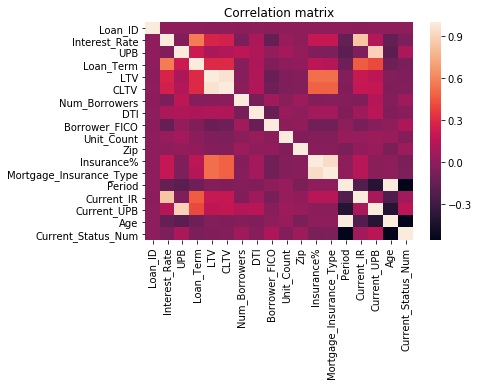

In [14]:
#correlation matrix
corr = _2004.corr()
sns.heatmap(corr,
           xticklabels = corr.columns.values,
           yticklabels = corr.columns.values)
plt.title('Correlation matrix')

In [23]:
a = corr.Current_Status_Num
cor = pd.DataFrame(a)
cor = cor.abs() #gives absolute values irrespective of sign
cor.sort_values('Current_Status_Num',ascending = False)

,Current_Status_Num
Current_Status_Num,1.000000
Period,0.553743
Age,0.553044
Current_UPB,0.160744
Borrower_FICO,0.108169
UPB,0.105709
Current_IR,0.068547
Loan_Term,0.068204
Num_Borrowers,0.064473
Insurance%,0.063009


In [26]:
#f test for DTI does DTI is different for current,Prepaid,underperforming
sc = _2004[_2004['Current_Status'] == 'Current']
sp = _2004[_2004['Current_Status'] == 'Prepaid']
su = _2004[_2004['Current_Status'] == 'Underperforming']

from scipy.stats import f_oneway
f_oneway(sc.Interest_Rate,sp.Interest_Rate,su.Interest_Rate)

F_onewayResult(statistic=412.2362757444384, pvalue=5.035991982632748e-179)

In [46]:
f_oneway(sc.Num_Borrowers,sp.Num_Borrowers)

F_onewayResult(statistic=228.9899535396161, pvalue=1.1349773806095602e-51)

In [28]:
#calculates percentages based on their category
def bar_plot_2(data,x,y,hue):
    plt.figure(figsize = (20,10))
    groupby = (data.groupby([x,hue])['Loan_ID'].count() / data.groupby([x])['Loan_ID'].count()).reset_index()
    chart = sns.barplot(x=x, hue=hue, y=y, data=groupby)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    chart.set( ylabel='Percentages')
    plt.show()

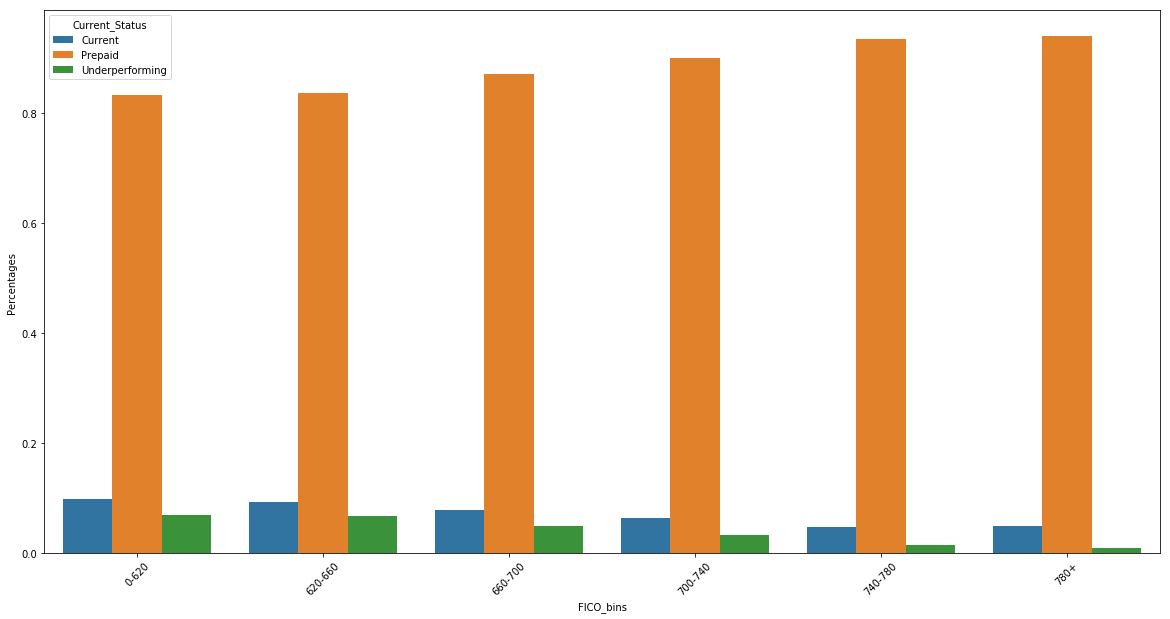

In [29]:
bar_plot_2(_2004,'FICO_bins','Loan_ID','Current_Status')

In [21]:
#calculates percentages with the base of each status
def bar_plot(data,x,y,hue):
    plt.figure(figsize = (20,10))
    groupby = (data.groupby([x,hue])['Loan_ID'].count() / data.groupby([hue])['Loan_ID'].count()).reset_index()
    chart = sns.barplot(x=x, hue=hue, y=y, data=groupby)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    chart.set( ylabel='Percentages')
    plt.show()

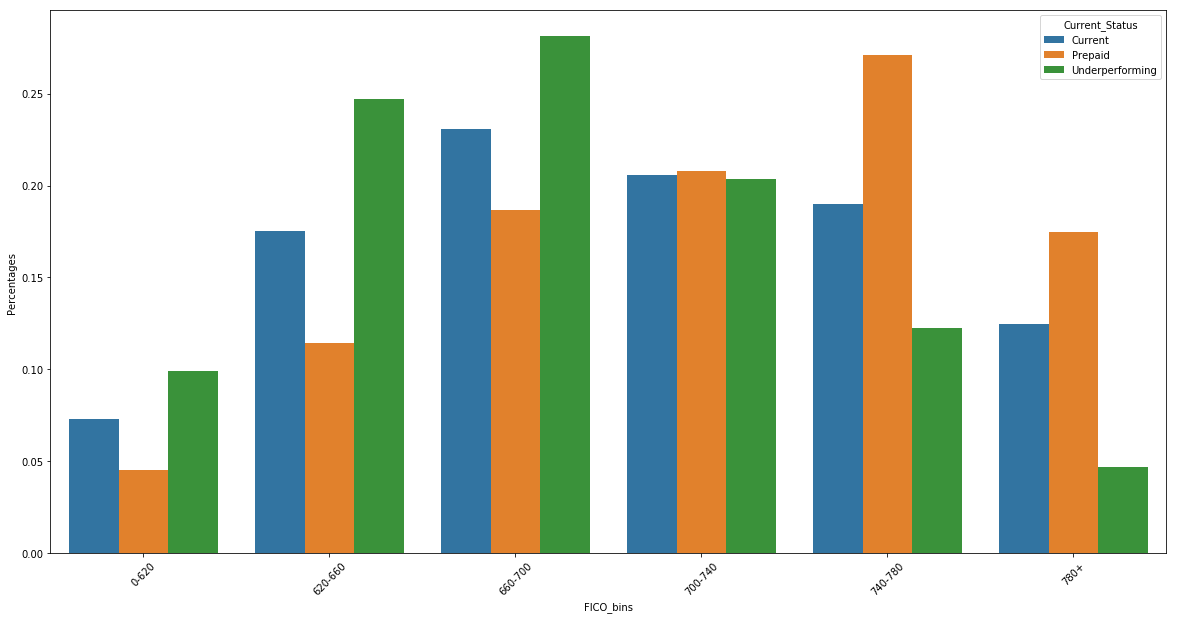

In [255]:
bar_plot(_2004,'FICO_bins','Loan_ID','Current_Status') #limit - 700 after that it is prepeaid

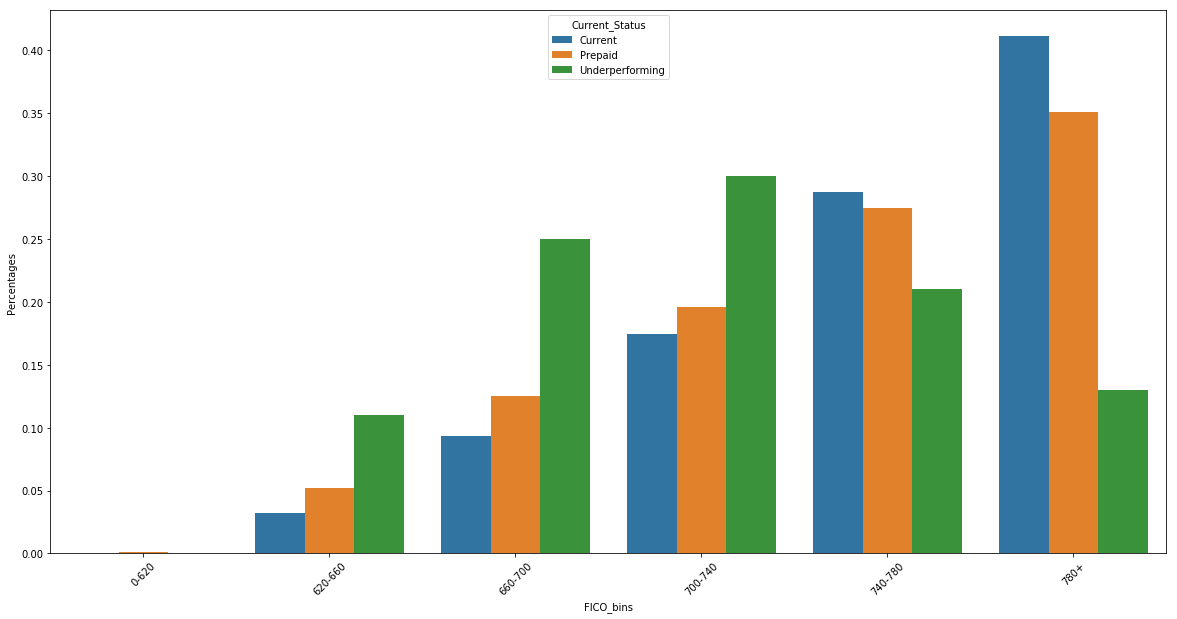

In [286]:
bar_plot(_2016,'FICO_bins','Loan_ID','Current_Status')

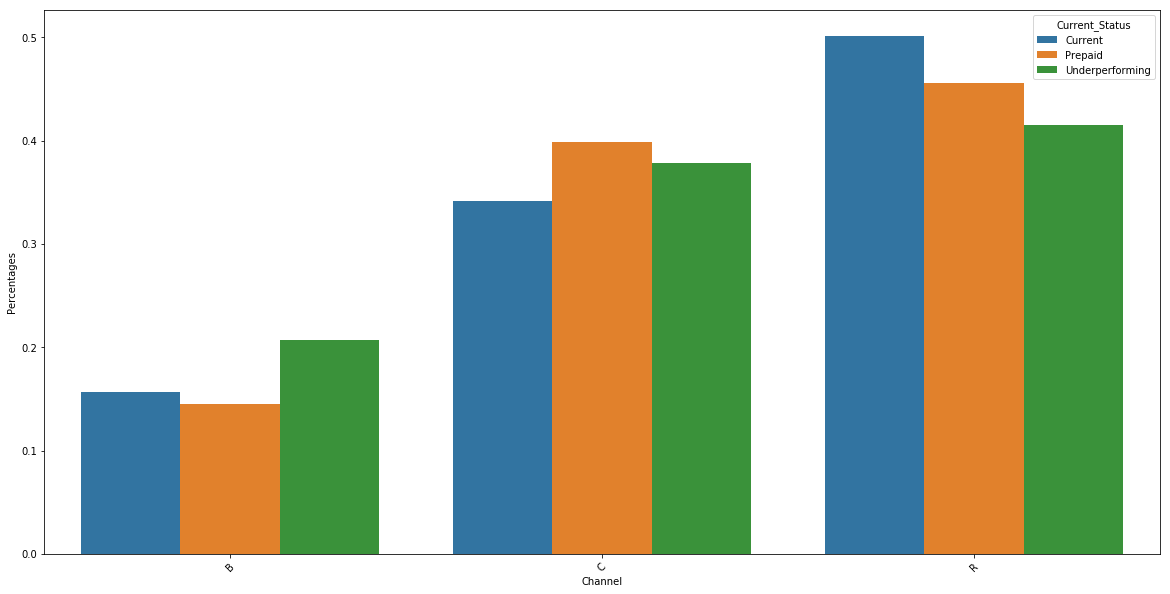

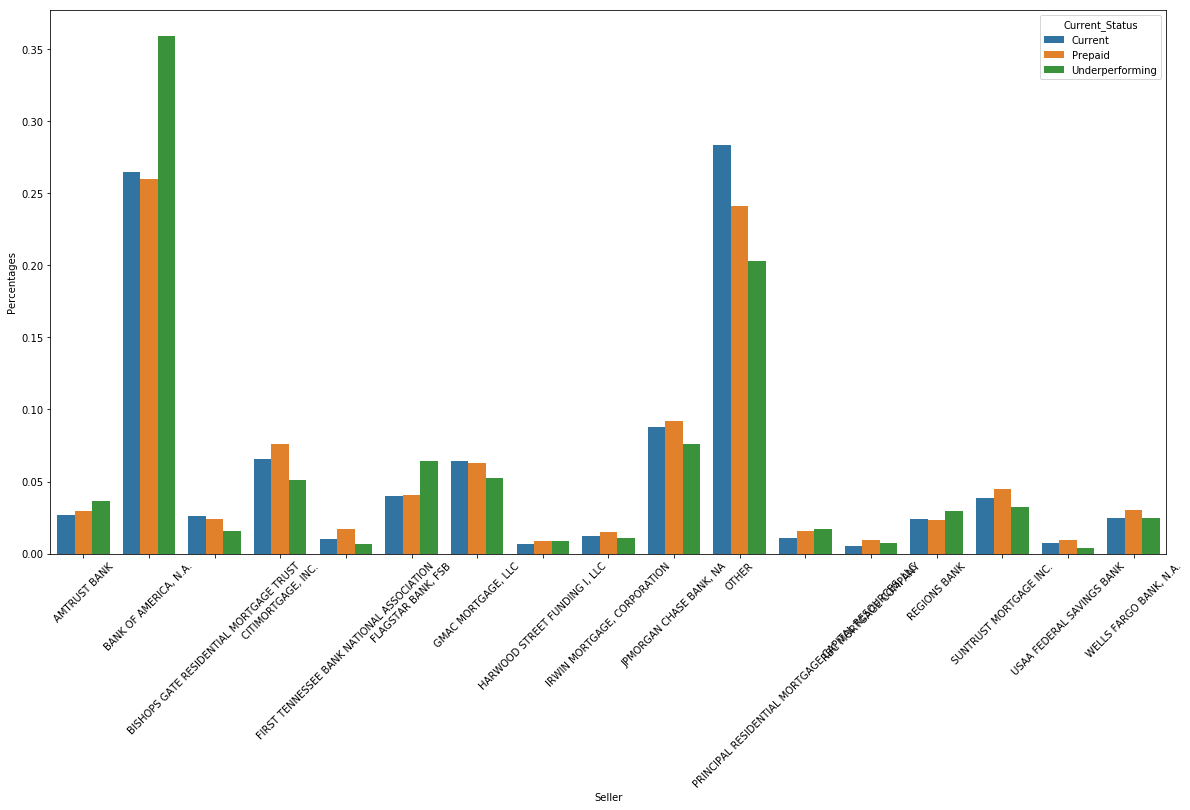

In [129]:
bar_plot(_2004,'Channel','Loan_ID','Current_Status')  #channel B has high underperforming loans
bar_plot(_2004,'Seller','Loan_ID','Current_Status')   #bank of america, first tennesse bank has high underperforming loans

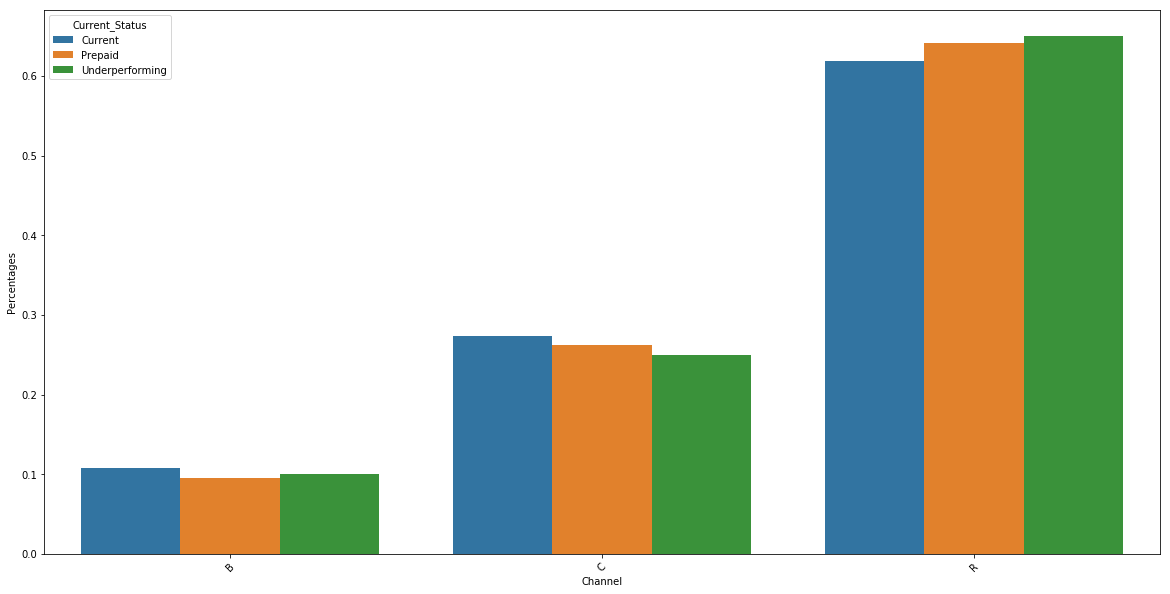

In [289]:
bar_plot(_2016,'Channel','Loan_ID','Current_Status')  #channel B has high underperforming loans
#bar_plot(_2016,'Seller','Loan_ID','Current_Status')   #bank of america, first tennesse bank has high underperforming loans

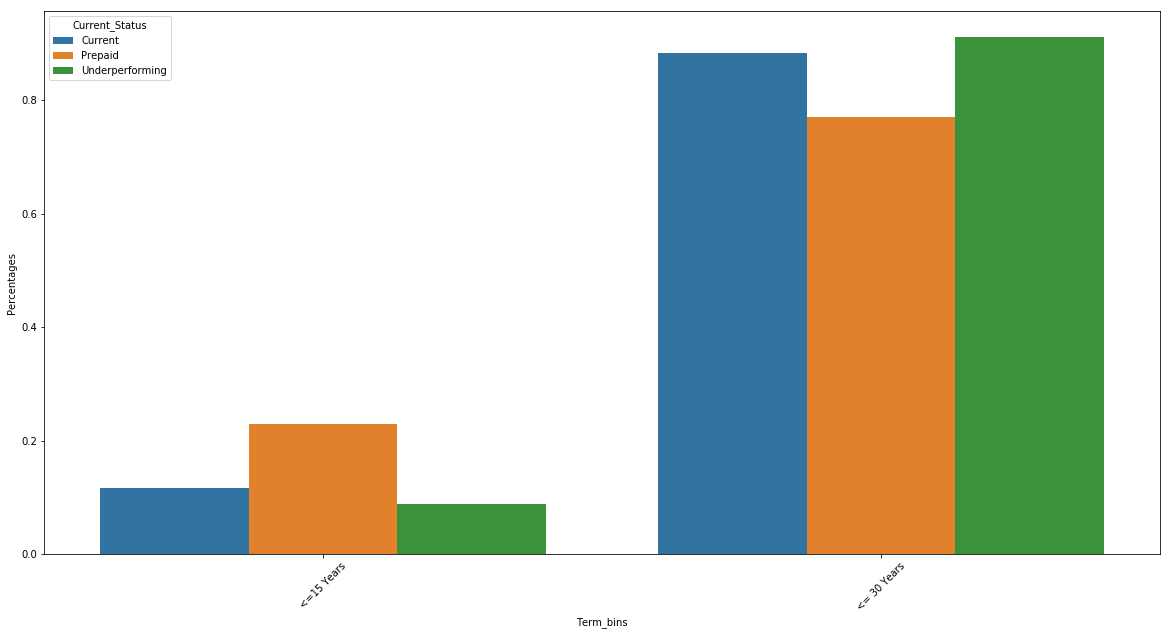

In [256]:
bar_plot(_2004,'Term_bins','Loan_ID','Current_Status')

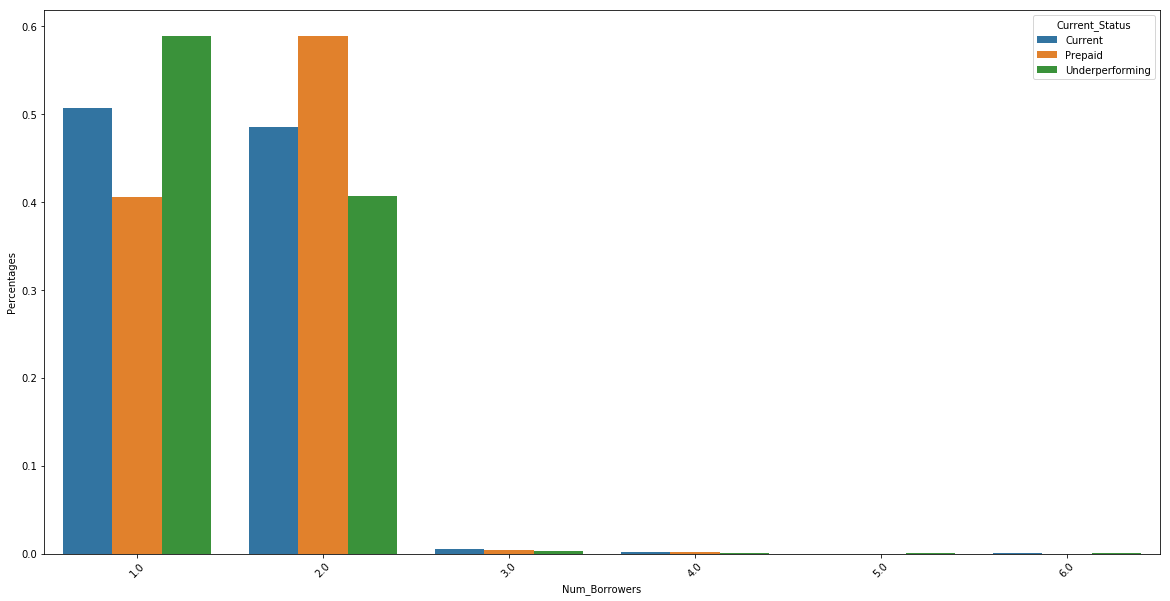

In [44]:
bar_plot(_2004,'Num_Borrowers','Loan_ID','Current_Status')

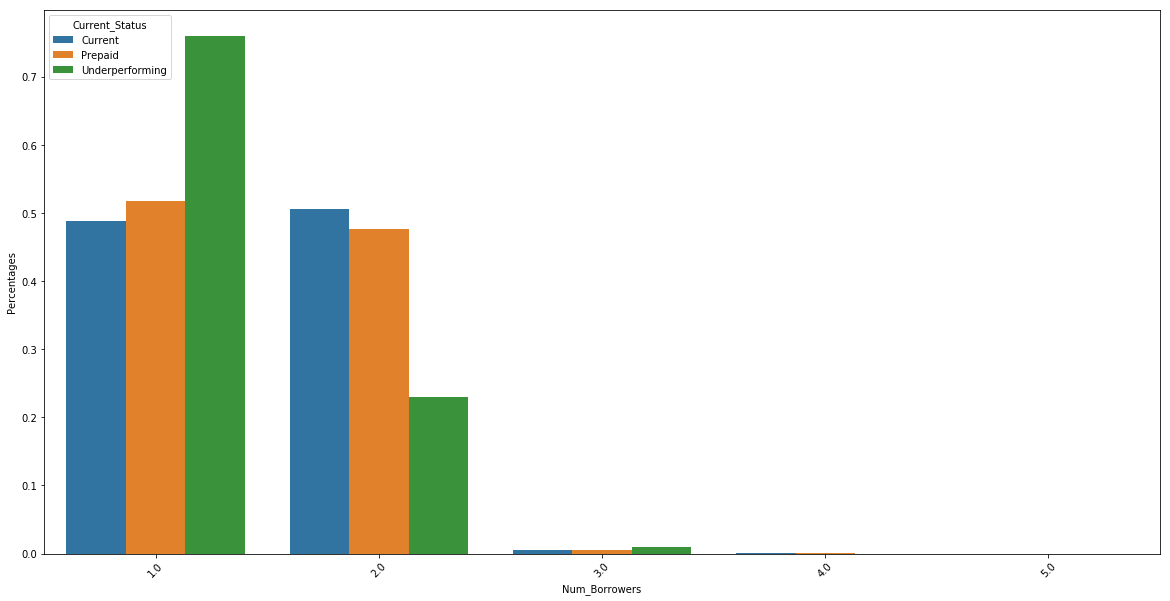

In [45]:
bar_plot(_2016,'Num_Borrowers','Loan_ID','Current_Status')

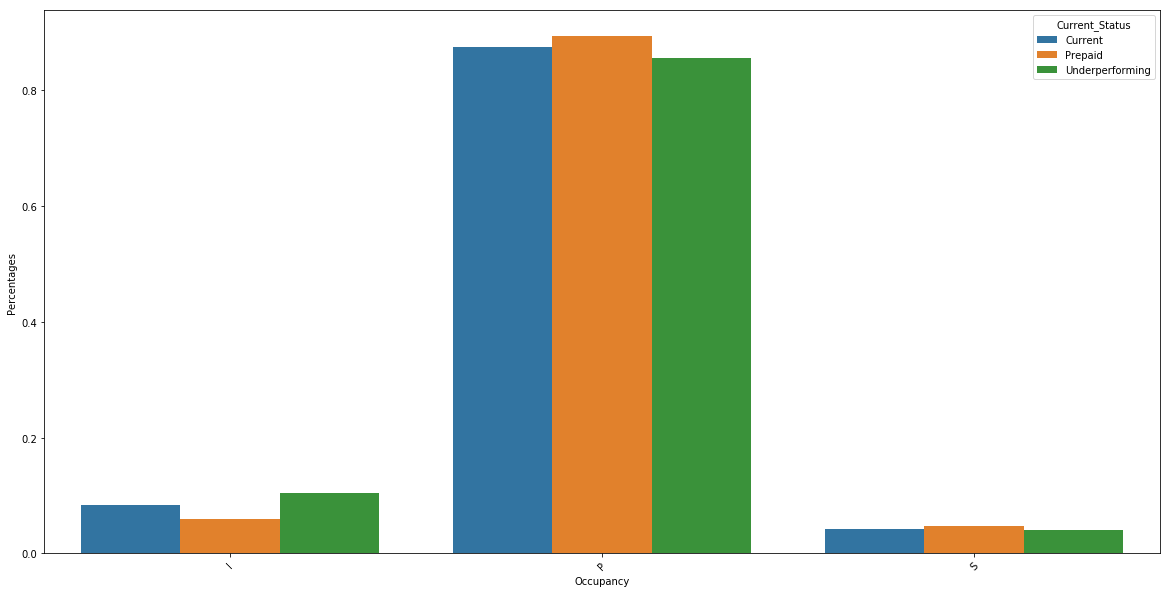

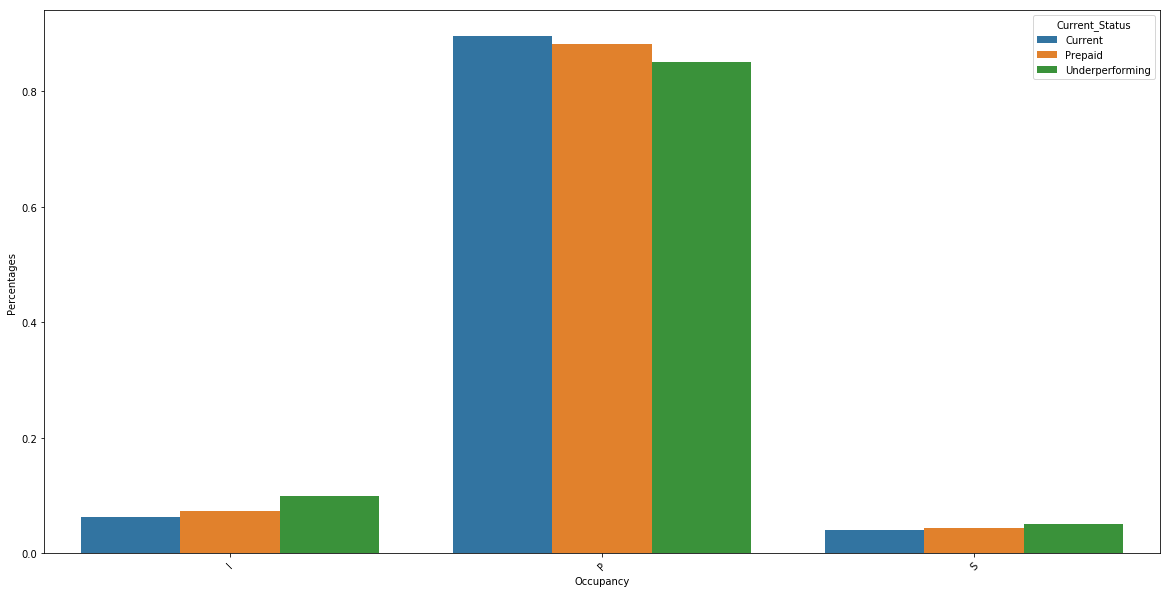

In [22]:
bar_plot(_2004,'Occupancy','Loan_ID','Current_Status')
bar_plot(_2016,'Occupancy','Loan_ID','Current_Status')

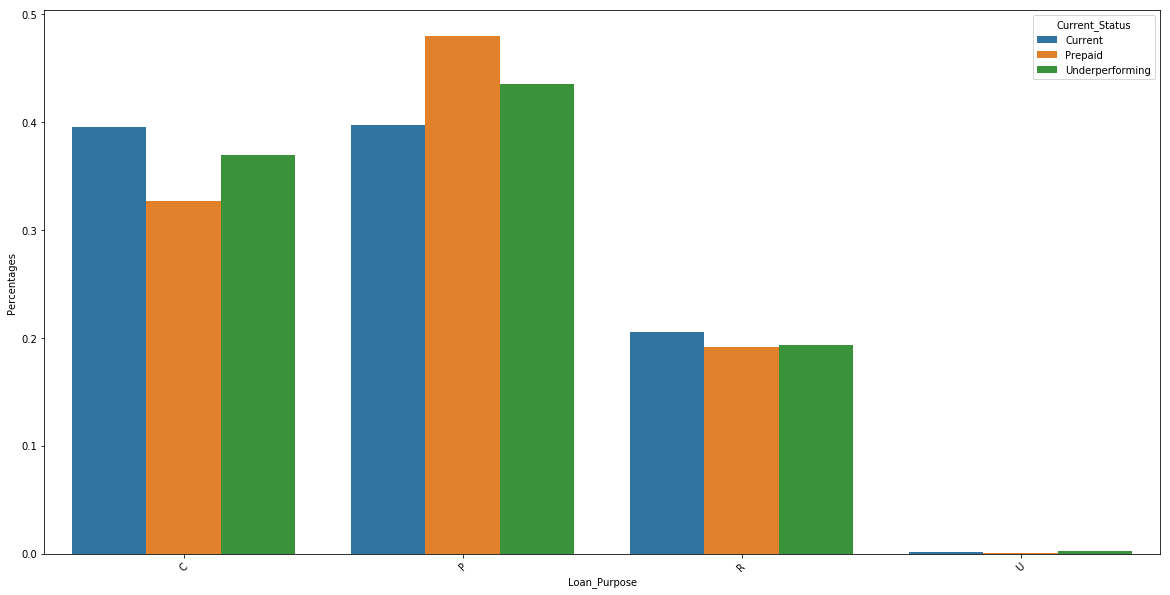

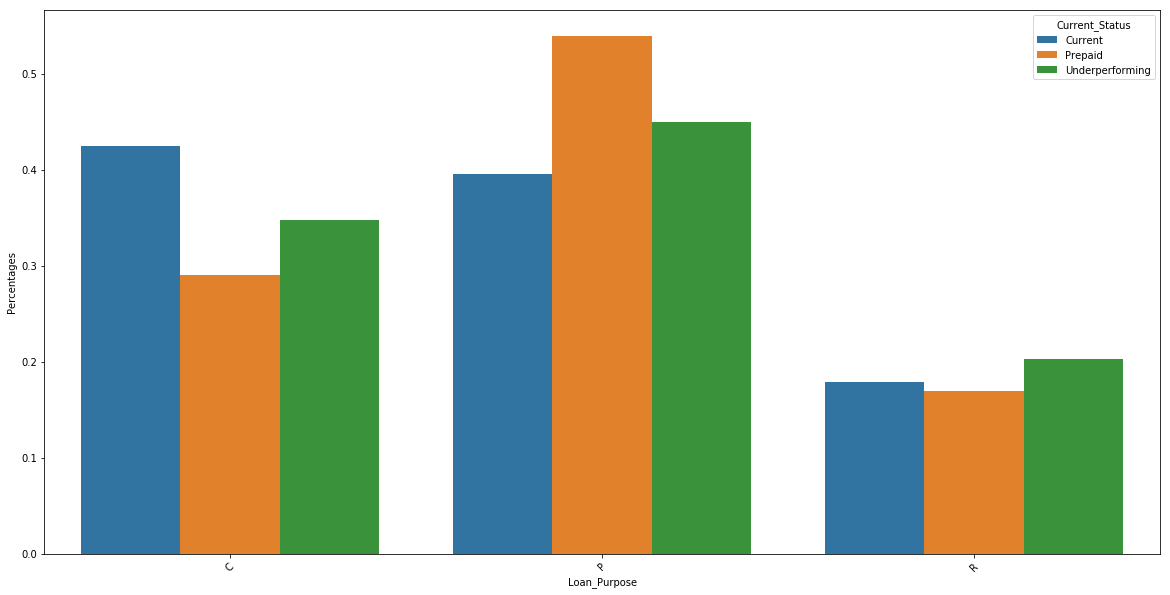

In [26]:
bar_plot(_2004,'Loan_Purpose','Loan_ID','Current_Status')
bar_plot(_2008,'Loan_Purpose','Loan_ID','Current_Status')

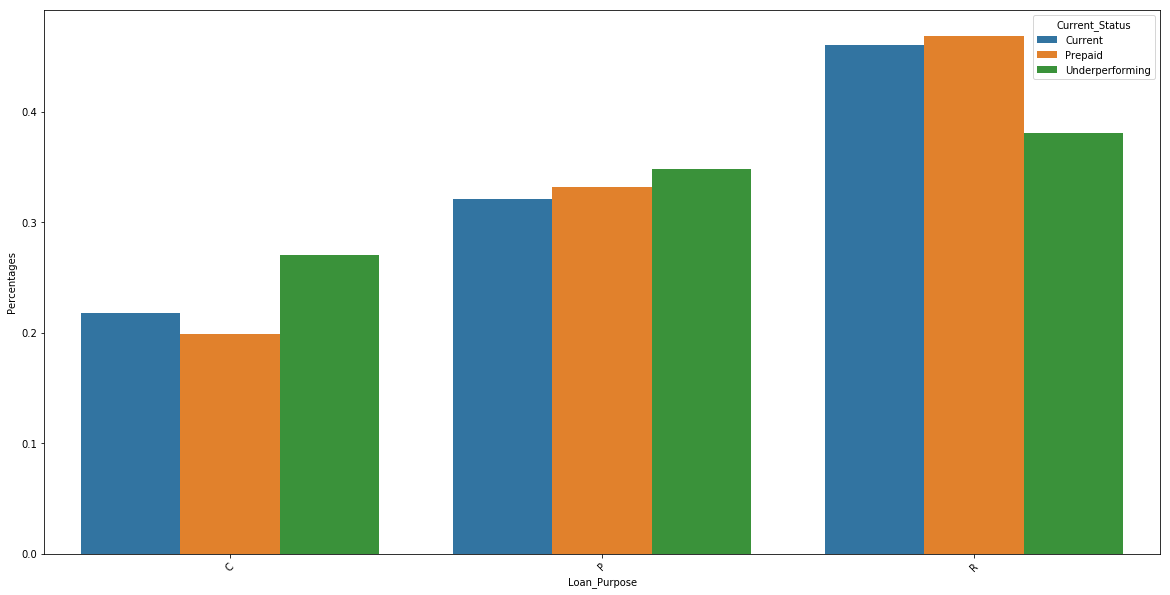

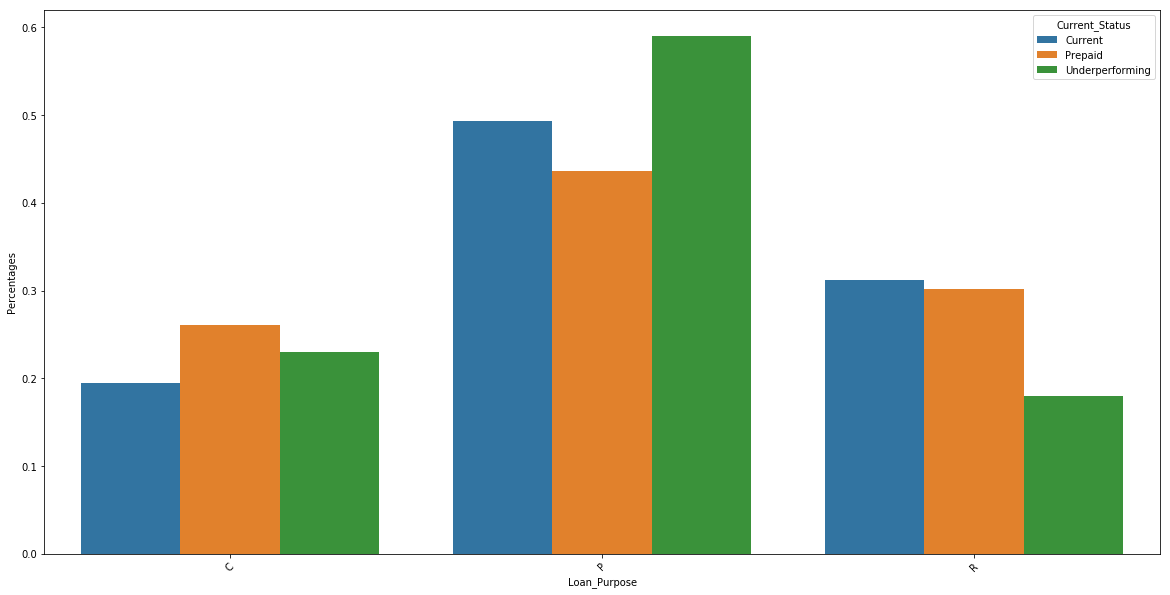

In [27]:
bar_plot(_2012,'Loan_Purpose','Loan_ID','Current_Status')
bar_plot(_2016,'Loan_Purpose','Loan_ID','Current_Status')

In [30]:
#create month columns
def get_months(data):
    data['Origination_Date'] = pd.to_datetime(data['Origination_Date'])
    data['months'] = pd.DatetimeIndex(data['Origination_Date']).month
    
get_months(_2004)
get_months(_2008)
get_months(_2012)
get_months(_2016)
#_2016.months

C:\Users\kalya\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\kalya\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
_2016.months.value_counts() #include only 5,6,7,8 months and do trends

8     31013
7     28334
6     24329
5      7522
9      7345
4      1064
3       241
2        54
1        38
12       35
11       25
Name: months, dtype: int64

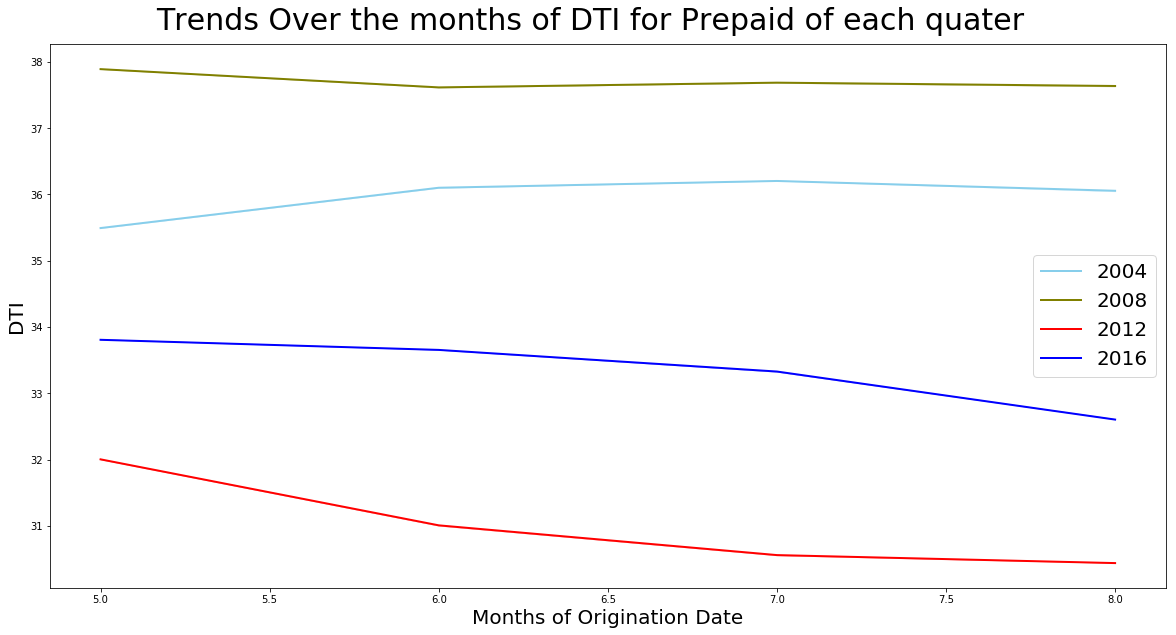

In [32]:
def plot_trends_2(var,status,months): 
    plt.figure(figsize=(20,10))
    sns.lineplot( _2004[(_2004['Current_Status'] == status) & (_2004['months'].isin(months))]['months'], _2004[var],estimator = 'mean',color = 'skyblue',linewidth=2,label = '2004',ci = 0)
    sns.lineplot( _2008[(_2008['Current_Status'] == status) & (_2008['months'].isin(months))]['months'], _2008[var], estimator = 'mean', color='olive', linewidth=2,label = '2008',ci = 0)
    sns.lineplot( _2012[(_2012['Current_Status'] == status) & (_2012['months'].isin(months))]['months'], _2012[var], estimator = 'mean', color='red', linewidth=2,label = '2012',ci = 0)
    sns.lineplot( _2016[(_2016['Current_Status'] == status) & (_2016['months'].isin(months))]['months'], _2016[var], estimator = 'mean', color='blue', linewidth=2,label = '2016',ci = 0)
    plt.xlabel('Months of Origination Date',fontsize = 20)
    plt.ylabel(var,fontsize = 20)
    plt.figtext(.5,.9,'Trends Over the months of ' + var + ' for ' + status + ' of each quater', fontsize=30, ha='center')
    plt.legend(prop={'size': 20})
    plt.show()
    
plot_trends_2('DTI','Prepaid',[5,6,7,8])

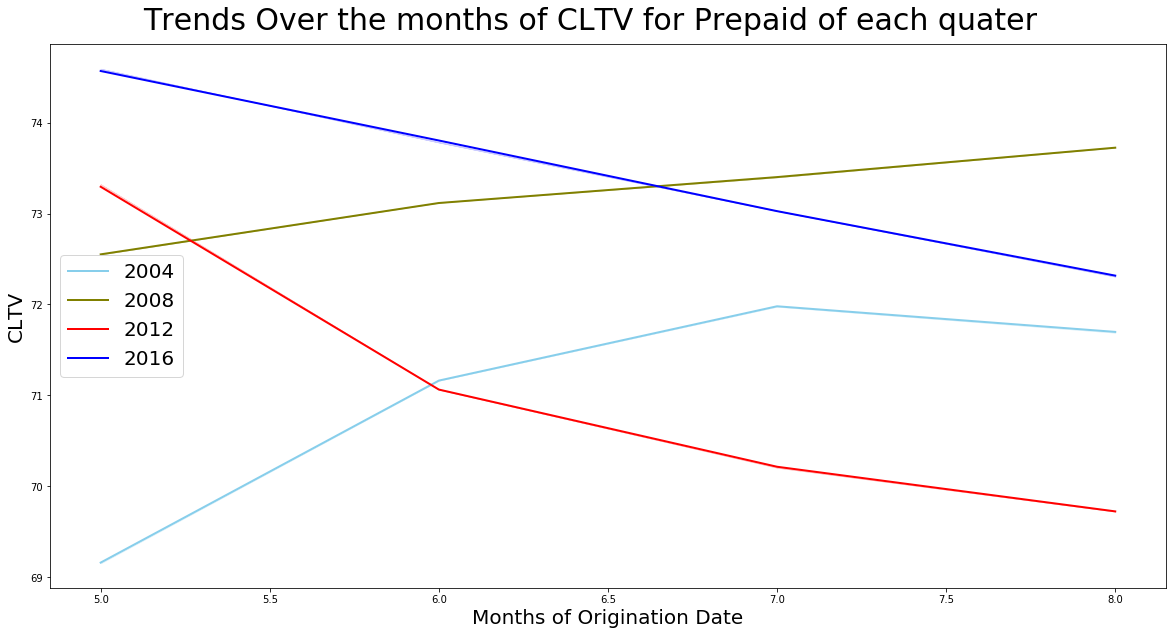

In [33]:
plot_trends_2('CLTV','Prepaid',[5,6,7,8])

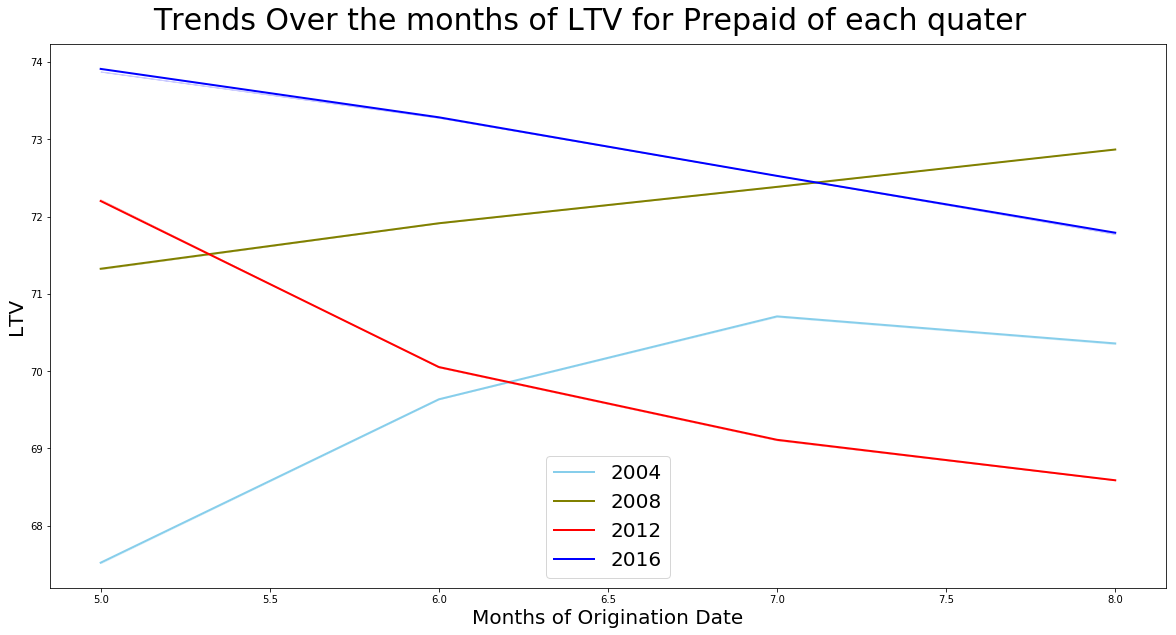

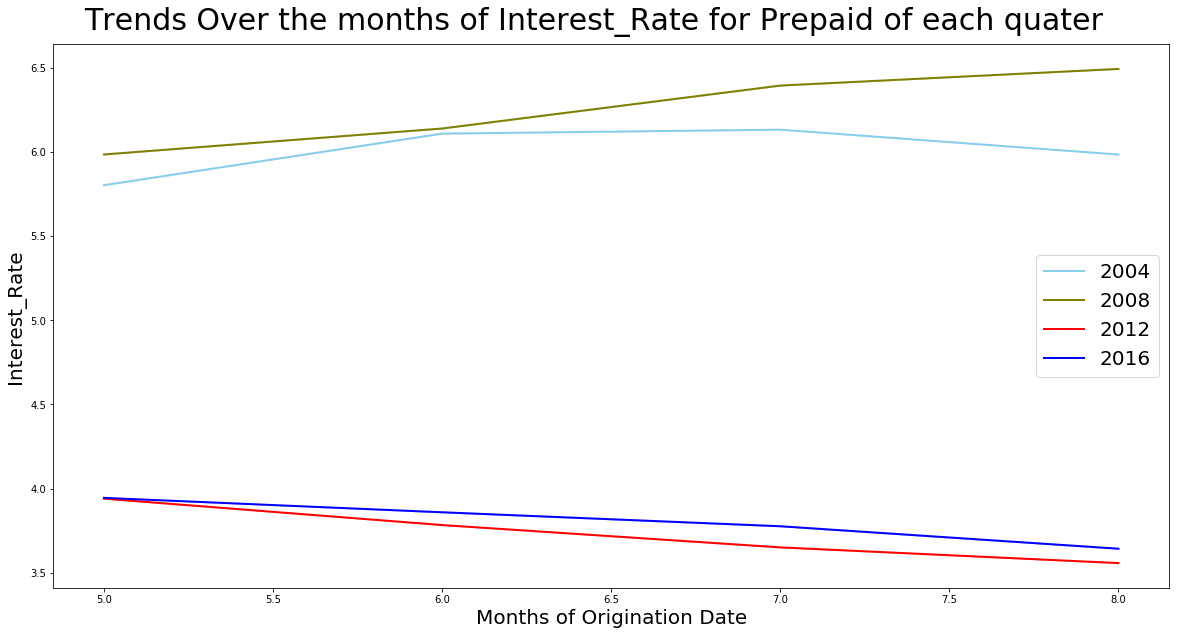

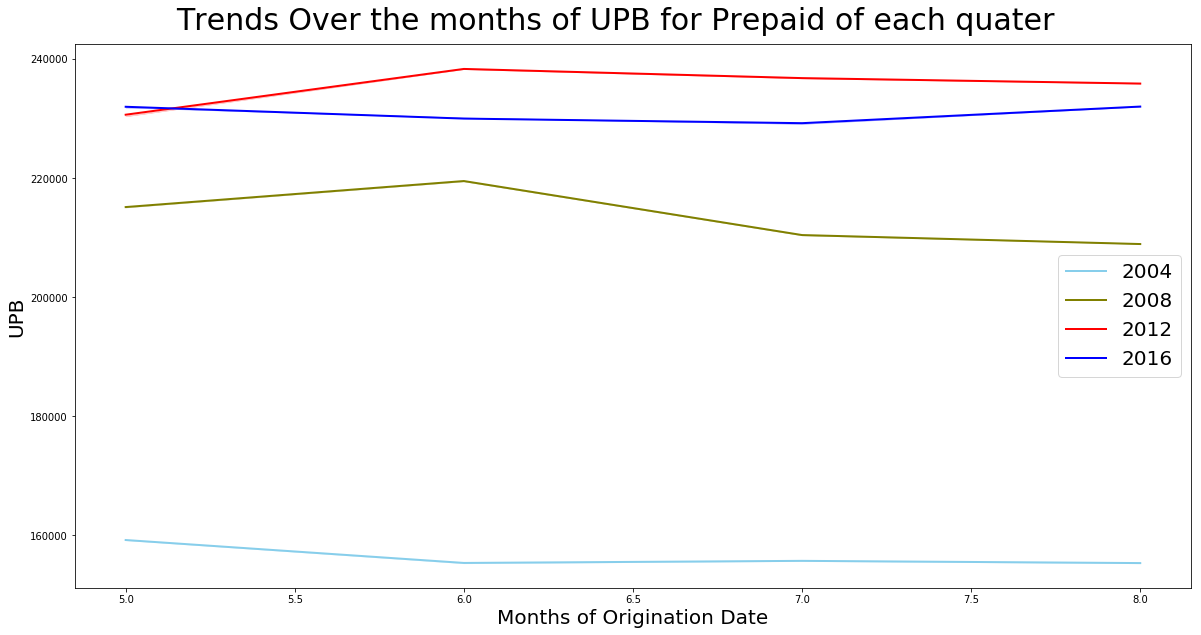

In [41]:
plot_trends_2('LTV','Prepaid',[5,6,7,8])
plot_trends_2('Interest_Rate','Prepaid',[5,6,7,8])
plot_trends_2('UPB','Prepaid',[5,6,7,8])

In [34]:
def plot_trends(var,status): 
    plt.figure(figsize=(20,10))
    sns.lineplot( _2004[_2004['Current_Status'] == status]['months'], _2004[var],estimator = 'mean',color = 'skyblue',label = '2004',ci = 0)
    sns.lineplot( _2008[_2008['Current_Status'] == status]['months'], _2008[var], estimator = 'mean', color='olive', linewidth=2,label = '2008',ci = 0)
    sns.lineplot( _2012[_2012['Current_Status'] == status]['months'], _2012[var], estimator = 'mean', color='red', linewidth=2,label = '2012',ci = 0)
    sns.lineplot( _2016[_2016['Current_Status'] == status]['months'], _2016[var], estimator = 'mean', color='blue', linewidth=2,label = '2016',ci = 0)
    plt.xlabel('Months of Origination Date',fontsize = 20)
    plt.ylabel(var,fontsize = 20)
    plt.figtext(.5,.9,'Trends Over the months of ' + var + ' for ' + status + ' of each quater', fontsize=30, ha='center')
    plt.legend(prop={'size': 20})
    plt.show()


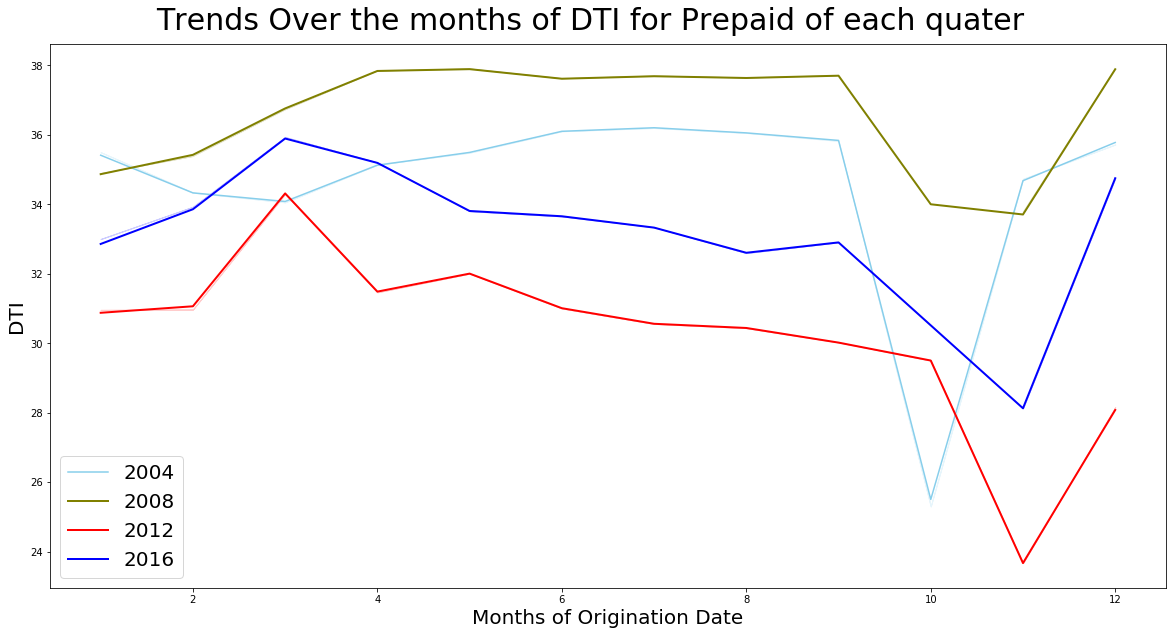

In [282]:
plot_trends('DTI','Prepaid')

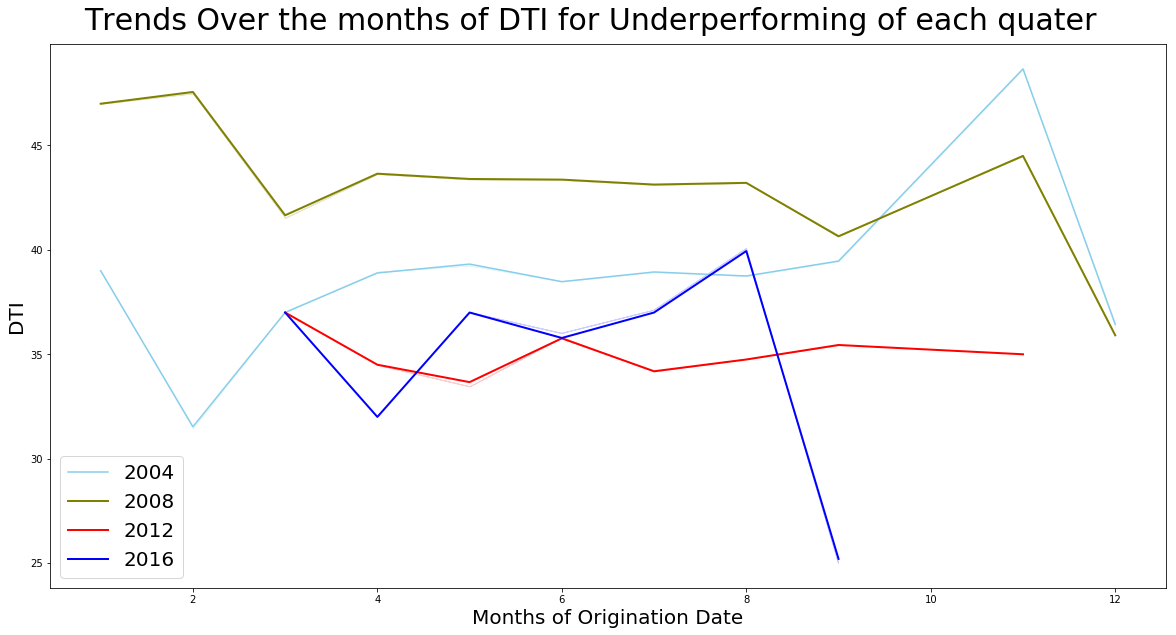

In [281]:
plot_trends('DTI','Underperforming')

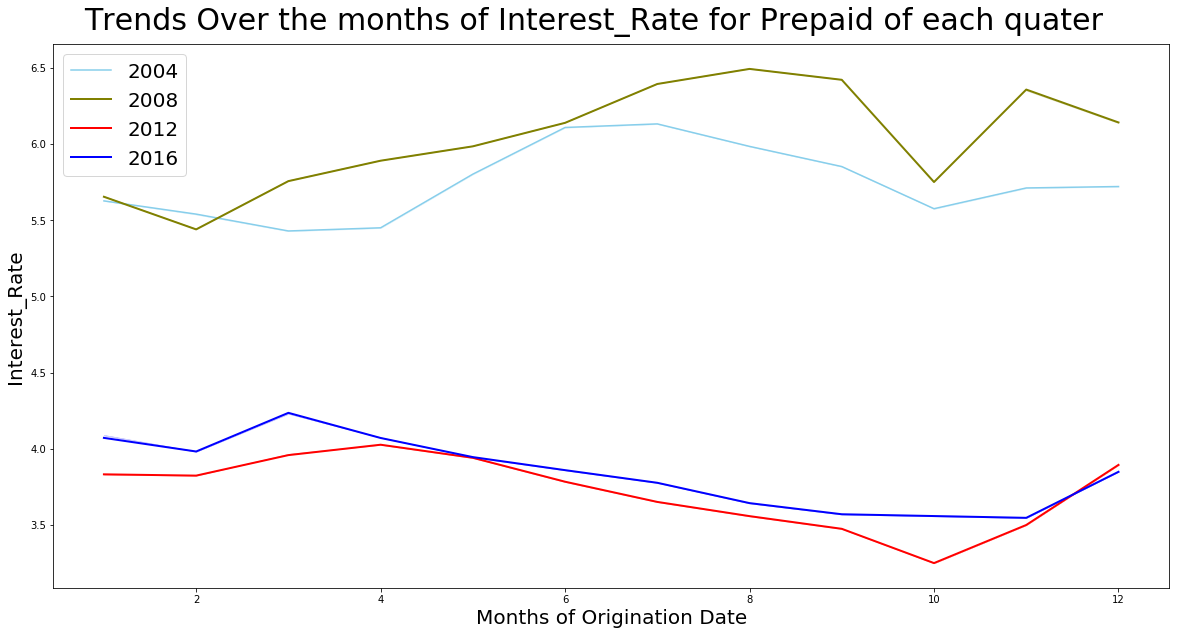

In [280]:
plot_trends('Interest_Rate','Prepaid')

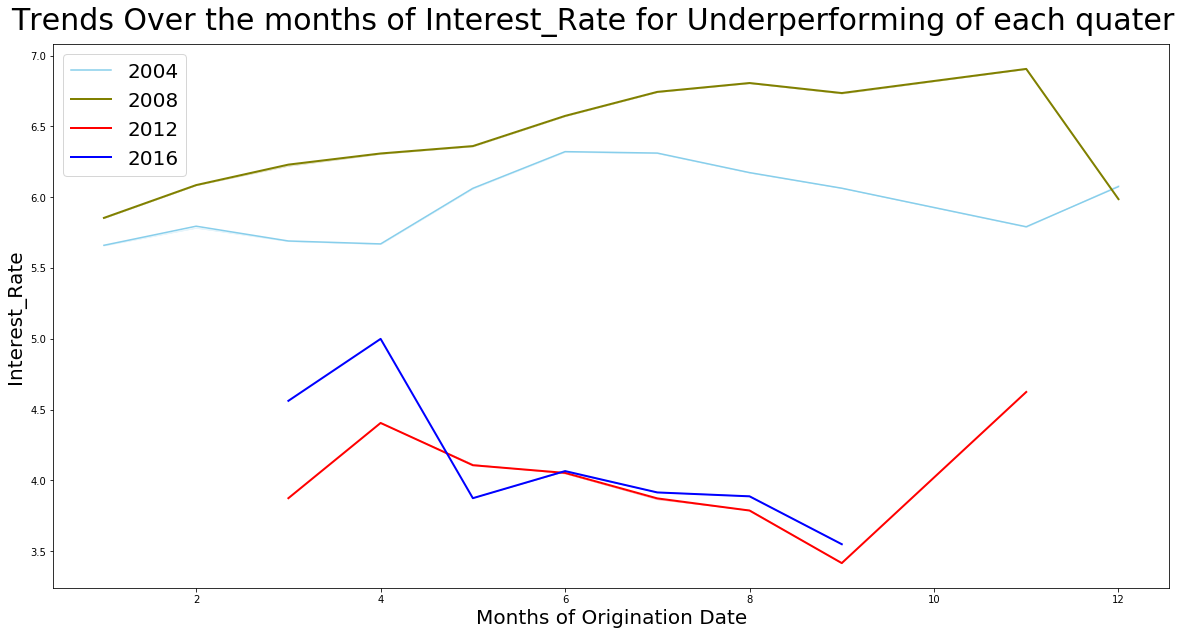

In [279]:
plot_trends('Interest_Rate','Underperforming')

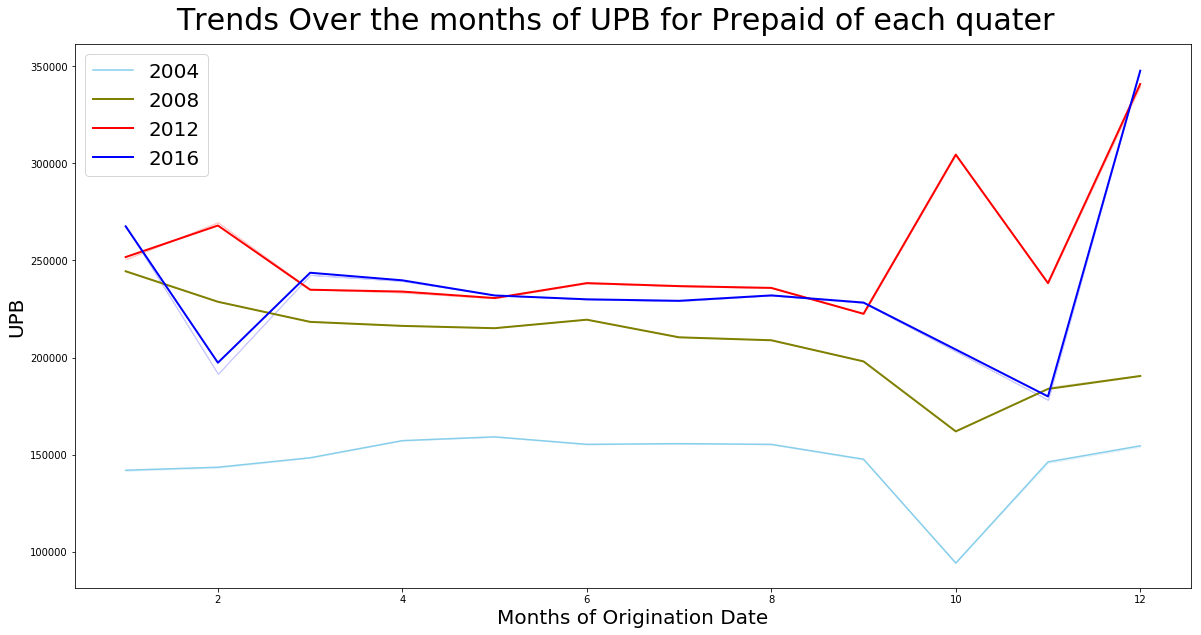

In [275]:
plot_trends('UPB','Prepaid')

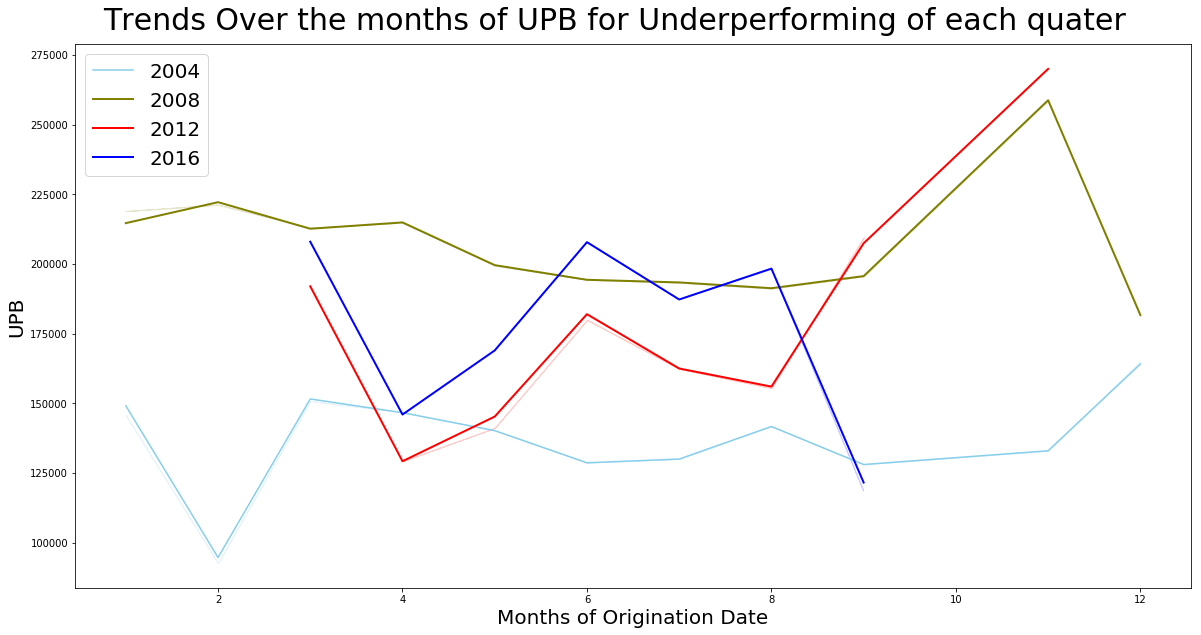

In [274]:
plot_trends('UPB','Underperforming')

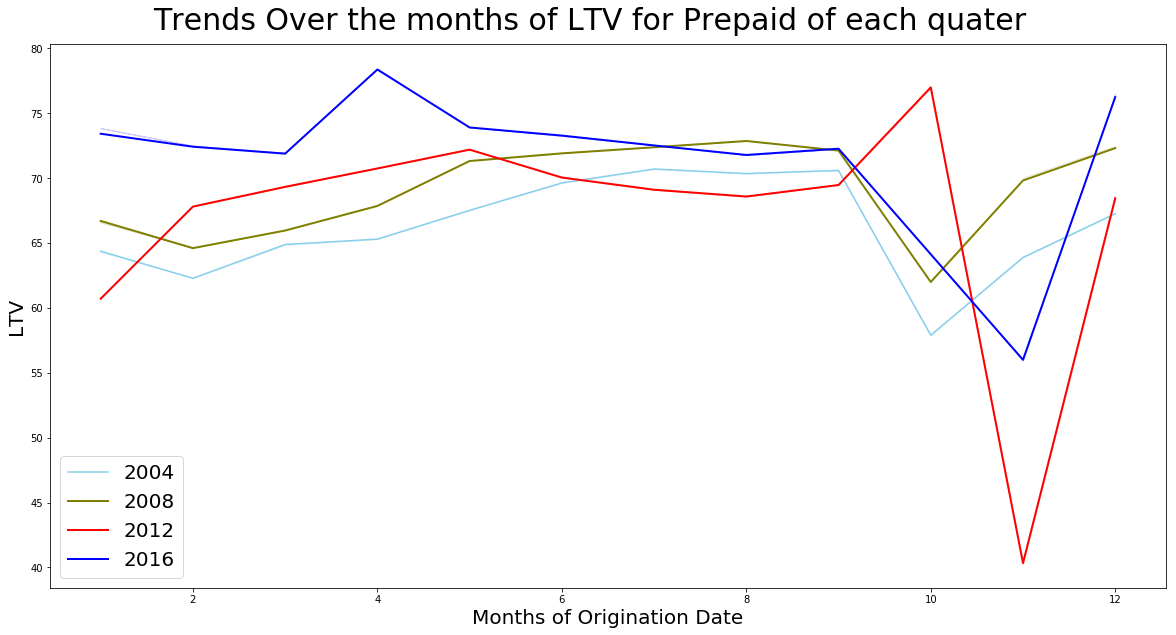

In [283]:
plot_trends('LTV','Prepaid')

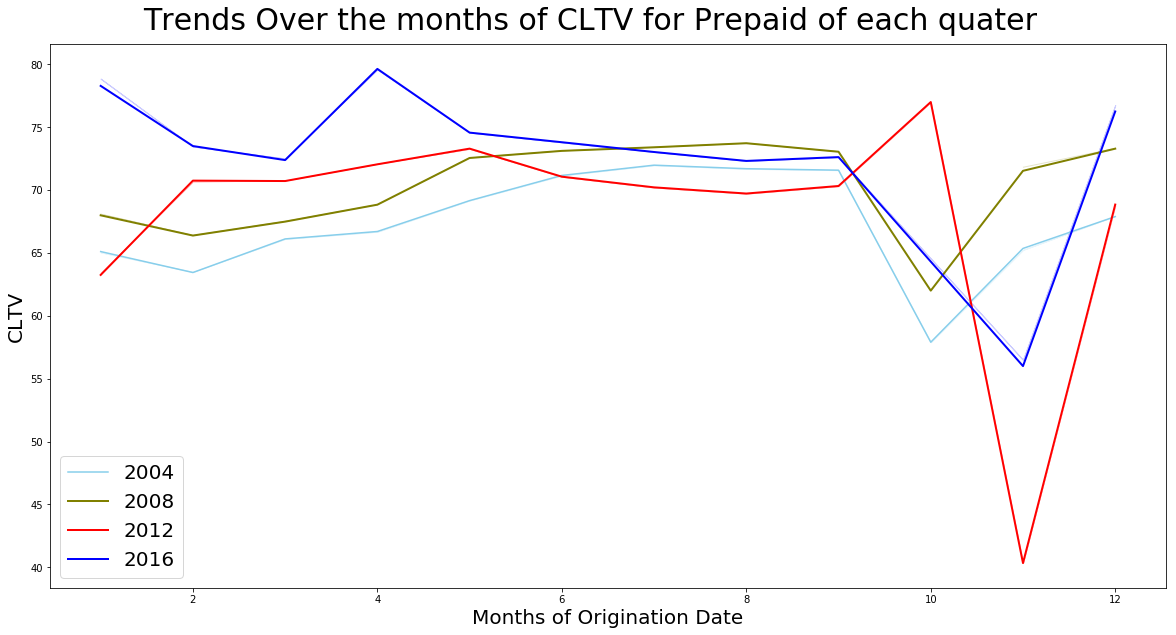

In [35]:
plot_trends('CLTV','Prepaid')

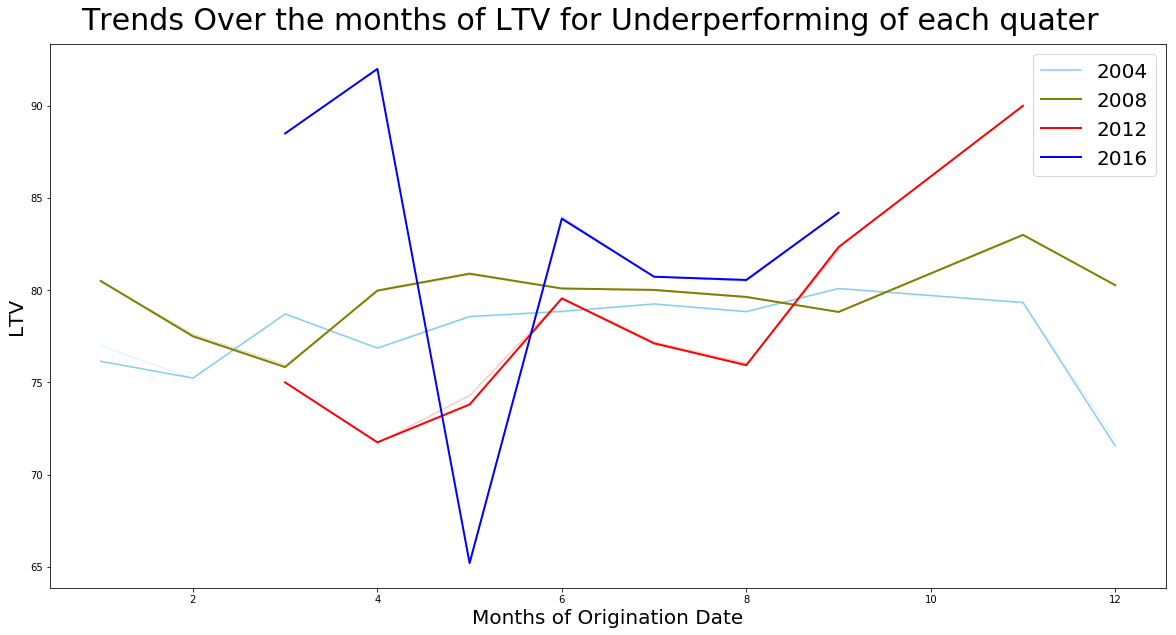

In [284]:
plot_trends('LTV','Underperforming')

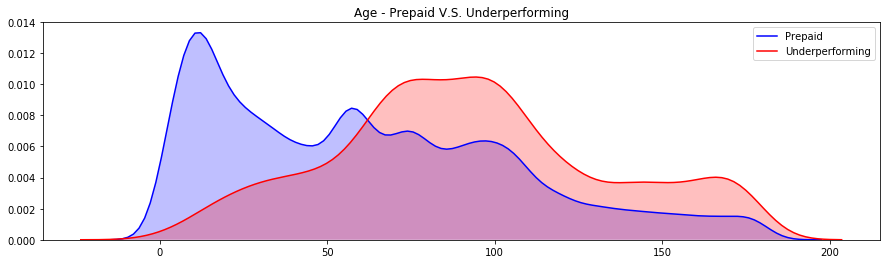

In [134]:
#KDEPlot: Kernel Density Estimate Plot
def density_plot(data,var):
    fig = plt.figure(figsize=(15,4))
    ax=sns.kdeplot(data.loc[(data['Current_Status'] == 'Prepaid'),var] , color='b',shade=True, label='Prepaid')
    ax=sns.kdeplot(data.loc[(data['Current_Status'] == 'Underperforming'),var] , color='r',shade=True, label='Underperforming')
    plt.title(var + ' - Prepaid V.S. Underperforming')
density_plot(_2004,'Age')

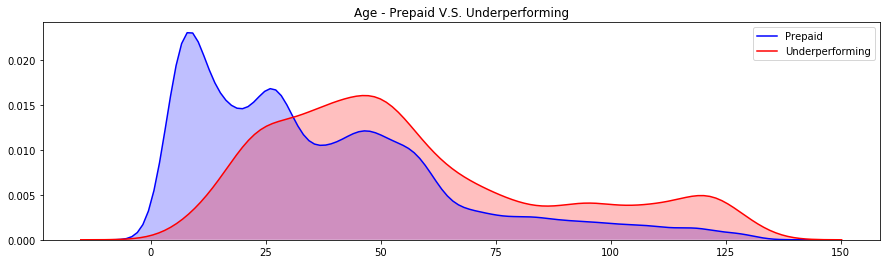

In [137]:
density_plot(_2008,'Age')

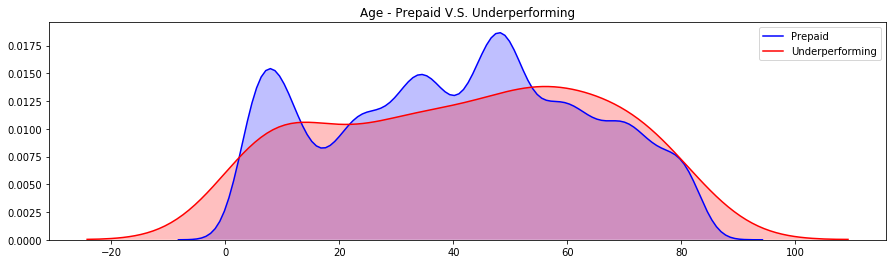

In [135]:
density_plot(_2012,'Age')

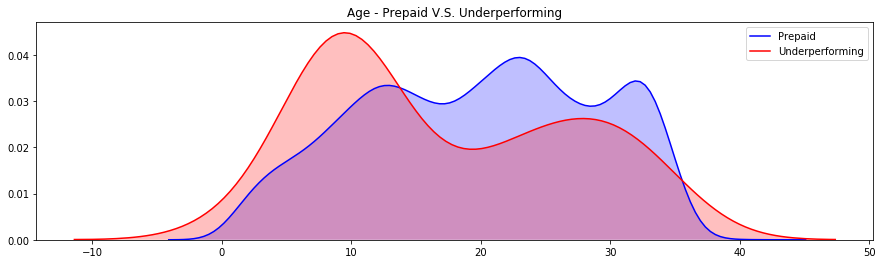

In [287]:
density_plot(_2016,'Age')

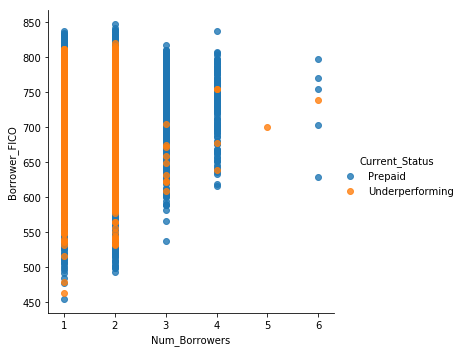

In [290]:
sns.lmplot(x='Num_Borrowers', y='Borrower_FICO', data=_2004[_2004['Current_Status'] != 'Current'],
           fit_reg=False, # No regression line
           hue='Current_Status')   # Color by evolution stage

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002ABBB4C1898>,
      dtype=object)

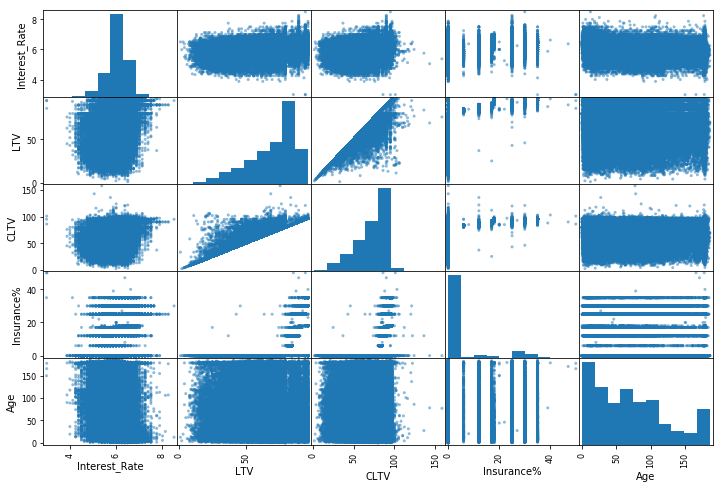

In [143]:
from pandas.plotting import scatter_matrix

attributes = ["Interest_Rate", "LTV", "CLTV",
              "Insurance%",'Age']
scatter_matrix(_2004[attributes],figsize = (12,8))

In [214]:
#clustering
cluster_data = _2004[_2004['Current_Status'] == 'Prepaid'][['Loan_ID','Num_Borrowers','Borrower_FICO','Loan_Purpose','Dwelling_Type','Occupancy','Age']] #Fico bins, first_time_buyer

onehot = OneHotEncoder()
scaler = StandardScaler()
cluster_data_dummies = pd.get_dummies(cluster_data)
cluster_data_scaled = StandardScaler().fit_transform(cluster_data_dummies.values)
cluster_df_scaled = pd.DataFrame(cluster_data_scaled, columns = cluster_data_dummies.columns)
cluster_df_scaled['Loan_ID'] = cluster_data['Loan_ID']
cluster_df_scaled.head()

,Loan_ID,Num_Borrowers,Borrower_FICO,Age,Loan_Purpose_C,Loan_Purpose_P,Loan_Purpose_R,Loan_Purpose_U,Dwelling_Type_CO,Dwelling_Type_CP,Dwelling_Type_MH,Dwelling_Type_PU,Dwelling_Type_SF,Occupancy_I,Occupancy_P,Occupancy_S
0,1.000015e+11,0.785327,-0.404206,1.105328,-0.697643,-0.960887,2.051715,-0.024725,-0.276968,-0.073901,-0.092148,-0.357915,0.497896,-0.249281,0.344019,-0.222868
1,1.000048e+11,0.785327,0.962364,0.725942,1.433397,-0.960887,-0.487397,-0.024725,-0.276968,-0.073901,-0.092148,-0.357915,0.497896,4.011541,-2.906813,-0.222868
2,NaN,-1.184852,-0.315468,1.172278,-0.697643,-0.960887,2.051715,-0.024725,-0.276968,-0.073901,-0.092148,-0.357915,0.497896,-0.249281,0.344019,-0.222868
3,1.000147e+11,0.785327,0.997860,0.279607,-0.697643,1.040705,-0.487397,-0.024725,-0.276968,-0.073901,-0.092148,2.793962,-2.008453,-0.249281,0.344019,-0.222868
4,1.000215e+11,0.785327,-0.475197,-0.099779,-0.697643,1.040705,-0.487397,-0.024725,-0.276968,-0.073901,-0.092148,2.793962,-2.008453,-0.249281,0.344019,-0.222868


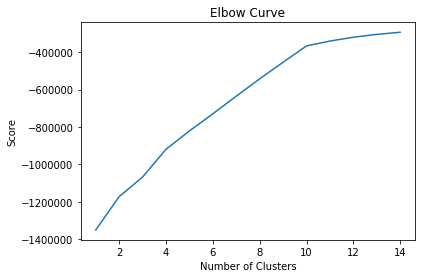

In [216]:
import pylab as pl
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Create K Clusters of 15
k = range(1, 15)

# Instantiate and Fit KMeans of Clusters 1-15
kmeans = [KMeans(n_clusters=i) for i in k]
score = [kmeans[i].fit(cluster_df_scaled[cluster_df_scaled.columns[1:]]).score(cluster_df_scaled[cluster_df_scaled.columns[1:]]) for i in range(len(kmeans))]

# Plot the Elbow Method
pl.plot(k,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [236]:
# Choose Cluster Size of 3
cluster = KMeans(n_clusters = 3) 


cluster_df_scaled["cluster"] = cluster.fit_predict(cluster_df_scaled[cluster_df_scaled.columns[1:]])

In [237]:
cluster_df_scaled.head()

,Loan_ID,Num_Borrowers,Borrower_FICO,Age,Loan_Purpose_C,Loan_Purpose_P,Loan_Purpose_R,Loan_Purpose_U,Dwelling_Type_CO,Dwelling_Type_CP,Dwelling_Type_MH,Dwelling_Type_PU,Dwelling_Type_SF,Occupancy_I,Occupancy_P,Occupancy_S,cluster
0,1.000015e+11,0.785327,-0.404206,1.105328,-0.697643,-0.960887,2.051715,-0.024725,-0.276968,-0.073901,-0.092148,-0.357915,0.497896,-0.249281,0.344019,-0.222868,1
1,1.000048e+11,0.785327,0.962364,0.725942,1.433397,-0.960887,-0.487397,-0.024725,-0.276968,-0.073901,-0.092148,-0.357915,0.497896,4.011541,-2.906813,-0.222868,1
2,NaN,-1.184852,-0.315468,1.172278,-0.697643,-0.960887,2.051715,-0.024725,-0.276968,-0.073901,-0.092148,-0.357915,0.497896,-0.249281,0.344019,-0.222868,1
3,1.000147e+11,0.785327,0.997860,0.279607,-0.697643,1.040705,-0.487397,-0.024725,-0.276968,-0.073901,-0.092148,2.793962,-2.008453,-0.249281,0.344019,-0.222868,2
4,1.000215e+11,0.785327,-0.475197,-0.099779,-0.697643,1.040705,-0.487397,-0.024725,-0.276968,-0.073901,-0.092148,2.793962,-2.008453,-0.249281,0.344019,-0.222868,2


In [238]:
#merge this with all columns
merged_with_cluster = pd.merge(cluster_data,cluster_df_scaled[['Loan_ID','cluster']],how = 'left',on = 'Loan_ID')
merged_with_cluster.head()

,Loan_ID,Num_Borrowers,Borrower_FICO,Loan_Purpose,Dwelling_Type,Occupancy,Age,cluster
0,100001458647,2.0,700.0,R,SF,P,111,1.0
1,100004788186,2.0,777.0,C,SF,I,94,1.0
2,100014656651,1.0,705.0,R,SF,P,114,2.0
3,100021529837,2.0,779.0,P,PU,P,74,2.0
4,100024441477,2.0,696.0,P,PU,P,57,0.0


In [239]:
#merge back
_2004_cluster_prepaid = pd.merge(_2004[_2004['Current_Status'] == 'Prepaid'],merged_with_cluster[['Loan_ID','cluster']],how = 'left',on = 'Loan_ID')
_2004_cluster_prepaid.head()

,Loan_ID,Channel,Seller,Interest_Rate,UPB,Loan_Term,Origination_Date,First_Payment_Date,LTV,CLTV,...,Current_UPB,Age,Mod_Ind,Zero_Bal_Cd,FICO_bins,Term_bins,Current_Status,Origin_Month,Origin_Year,cluster
0,100001458647,R,"CITIMORTGAGE, INC.",5.625,297000,360,05/2004,07/2004,49,61.0,...,251567.64,111,N,Prepaid,660-700,<= 30 Years,Prepaid,07,2004,1.0
1,100004788186,C,"BANK OF AMERICA, N.A.",5.750,50000,180,08/2004,10/2004,25,25.0,...,12621.76,94,N,Prepaid,740-780,<=15 Years,Prepaid,10,2004,1.0
2,100014656651,C,"BANK OF AMERICA, N.A.",6.300,55000,240,07/2004,09/2004,80,80.0,...,37473.50,114,N,Prepaid,700-740,<= 30 Years,Prepaid,09,2004,2.0
3,100021529837,C,"BANK OF AMERICA, N.A.",5.875,140000,360,07/2004,09/2004,80,80.0,...,119759.31,74,N,Prepaid,740-780,<= 30 Years,Prepaid,09,2004,2.0
4,100024441477,B,SUNTRUST MORTGAGE INC.,6.250,119000,360,06/2004,08/2004,80,80.0,...,111867.54,57,N,Prepaid,660-700,<= 30 Years,Prepaid,08,2004,0.0


In [241]:
_2004_cluster_prepaid.groupby('cluster')['Interest_Rate','LTV','Borrower_FICO','Age','Current_UPB','DTI'].mean()

,Interest_Rate,LTV,Borrower_FICO,Age,Current_UPB,DTI
cluster,,,,,,
0.0,6.008378,69.638116,722.798717,61.514685,130706.536866,36.001382
1.0,6.003712,69.710627,722.918038,61.541253,130318.188097,35.871281
2.0,6.008090,69.518113,722.400634,61.237257,130814.755276,35.939358
